In [1]:
import json

import anndata
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq

from squidpy_utils.io import load_visium_kallisto

In [2]:
fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spatial_pallium/113D/output.sort_em.mtx'


gene_fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spatial_pallium/113D/output.sort_em.genes.txt'
barcode_fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spatial_pallium/113D/output.sort_em.barcodes.txt'

tissue_positions_list = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spaceranger/113D/files/tissue_positions_list.csv'

scalefactors_fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spaceranger/113D/files/scalefactors_json.json'

hires_fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spaceranger/113D/files/tissue_hires_image.png'
lowres_fname = '/Users/kyamauch/Documents/visium/20210212_P1441_ASHLEY_VISIUM_visium_52min_axolotl_brain/spaceranger/113D/files/tissue_lowres_image.png'



In [3]:
adata_113D = load_visium_kallisto(
    counts_table=fname,
    gene_names=gene_fname,
    barcodes=barcode_fname,
    tissue_positions_list=tissue_positions_list,
    scale_factors=scalefactors_fname,
    hires_im=hires_fname,
    lowres_im=lowres_fname,
    library_id='113D'
)

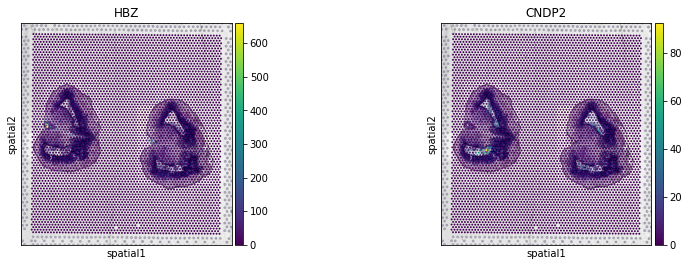

In [4]:
sc.pl.spatial(adata_113D, img_key="hires", color=['HBZ', 'CNDP2'])

In [5]:
adata_113D.obs

,barcode,barcode_raw,in_tissue,array_col,array_row,im_x,im_y
0,AAACAACGAATAGTTC,AAACAACGAATAGTTC-1,0,0,16,3407,5082
1,AAACAAGTATCTCCCA,AAACAAGTATCTCCCA-1,1,50,102,16220,17539
2,AAACAATCTACTAGCA,AAACAATCTACTAGCA-1,0,3,43,4203,9020
3,AAACACCAATAACTGC,AAACACCAATAACTGC-1,0,59,19,18407,5396
4,AAACAGAGCGACTCCT,AAACAGAGCGACTCCT-1,0,14,94,7060,16446
...,...,...,...,...,...,...,...
4985,TTGTTTCACATCCAGG,TTGTTTCACATCCAGG-1,0,58,42,18180,8758
4986,TTGTTTCATTAGTCTA,TTGTTTCATTAGTCTA-1,0,60,30,18674,7001
4987,TTGTTTCCATACAACT,TTGTTTCCATACAACT-1,1,45,27,14858,6594
4988,TTGTTTGTATTACACG,TTGTTTGTATTACACG-1,0,73,41,21992,8580


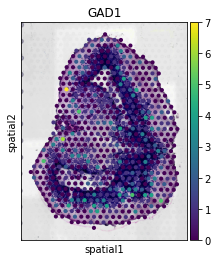

In [6]:
# crop around one of the brain slices
adata_split = adata_113D[adata_113D.obs.array_row < 65, :]
adata_split = adata_split[adata_split.obs.in_tissue == 1, :]

sc.pl.spatial(adata_split, img_key="hires", color=['GAD1'])

In [7]:
# add annotations for mito genes
mito_genes = [
    'COX1',
    'COX2',
    'COX3',
    'ATP6',
    'ND1',
    'ND5',
    'CYTB',
    'ND2',
    'ND4',
    'ATP8',
    'MT-CO1',
    'COI',
    'LOC9829747'
]
adata_split.var['mt'] = adata_split.var_names.isin(mito_genes)

# calculate qc metrics
sc.pp.calculate_qc_metrics(adata_split, qc_vars=["mt"], inplace=True)



Trying to set attribute `.var` of view, copying.


/Users/kyamauch/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kyamauch/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kyamauch/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='n_genes_by_counts'>

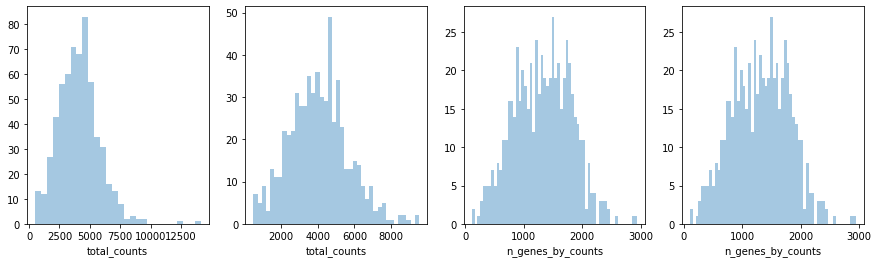

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata_split.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata_split.obs["total_counts"][adata_split.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata_split.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata_split.obs["n_genes_by_counts"][adata_split.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])



In [9]:
sc.pp.normalize_total(adata_split, inplace=True)
sc.pp.log1p(adata_split)
sc.pp.highly_variable_genes(adata_split, flavor="seurat", n_top_genes=2000)

In [10]:
sc.pp.pca(adata_split)
sc.pp.neighbors(adata_split)
sc.tl.umap(adata_split)
sc.tl.leiden(adata_split, key_added="clusters")

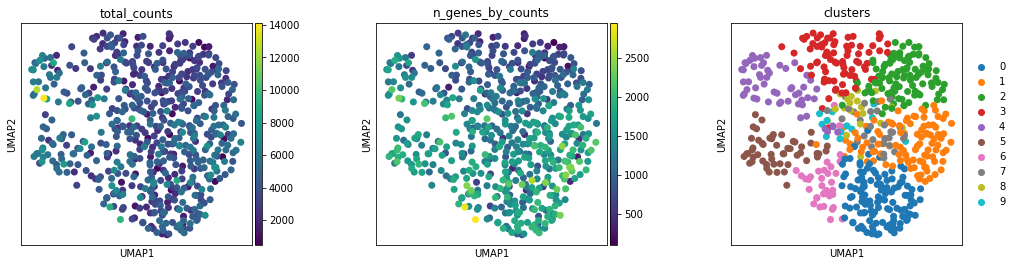

In [11]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_split, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

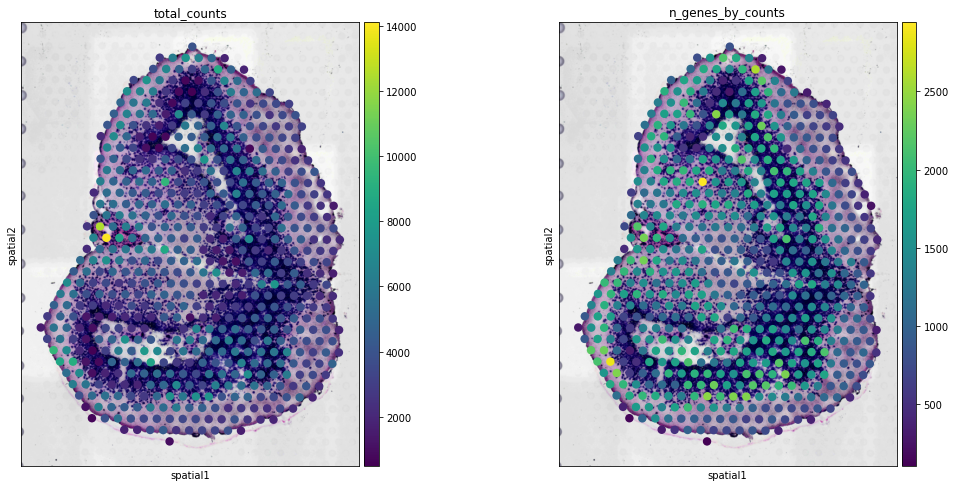

In [12]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_split, img_key="hires", color=["total_counts", "n_genes_by_counts"])



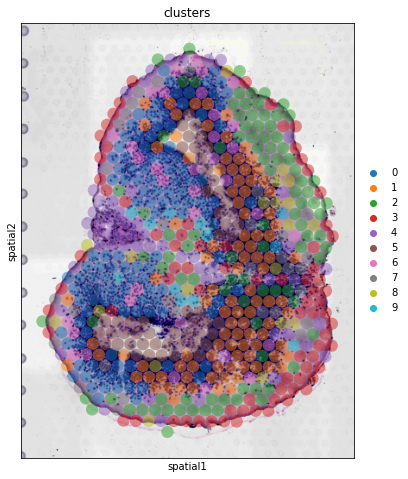

In [13]:
sc.pl.spatial(adata_split, img_key="hires", color="clusters", size=1.5, alpha=0.5)

In [14]:
# create the squidpy ImageContainer object.
# since we are using the "hires" image instead of the raw image,
# we have to rescale the coordinates and reset the scale factors
# in the real analysis, we would use the raw image, which is much bigger
img = sq.im.ImageContainer(adata_split.uns['spatial']['113D']['images']['hires'])
adata = adata_split

old_coords = adata.obsm['spatial']
scale_factor = adata.uns['spatial']['113D']['scalefactors']['tissue_hires_scalef']
new_coords = scale_factor * old_coords
adata.obsm['spatial'] = new_coords.astype(int)

# update the scale factors
adata.uns['spatial']['113D']['scalefactors']['tissue_hires_scalef'] = 1
adata.uns['spatial']['113D']['scalefactors']['spot_diameter_fullres'] = 3

In [15]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img,
        features="summary",
        key_added=feature_name,
        n_jobs=1,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = anndata.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/604 [00:00<?, ?/s]

  0%|          | 0/604 [00:00<?, ?/s]

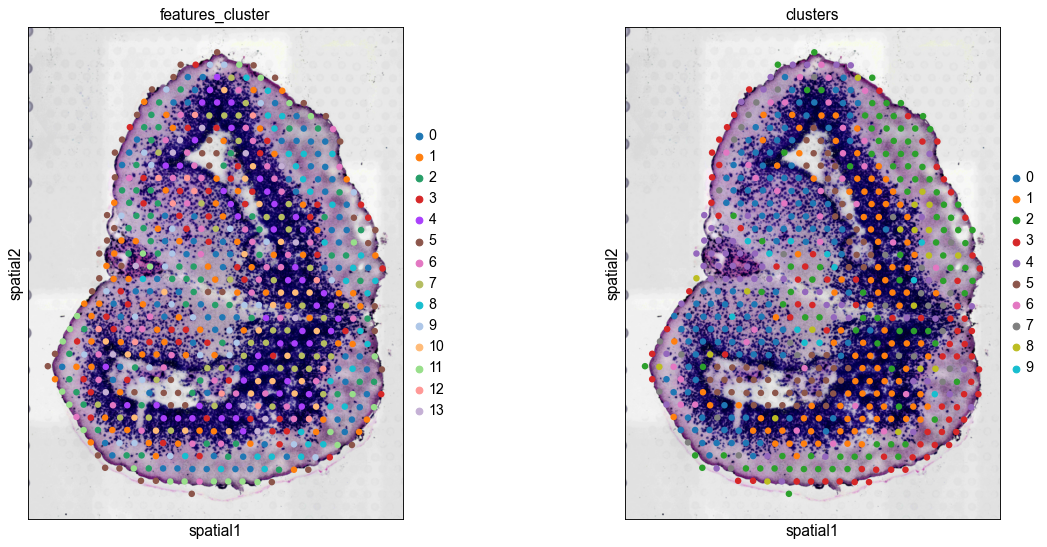

In [17]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None):
    """Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = anndata.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "clusters"], spot_size=10)